# Predicting the fitness of isomerases without experimental data

Chorismate Mutase (EC 5.4.99.5) (CM) holds a pivotal role in the biosynthesis of biological compounds, facilitating a crucial chemical reaction in the shikimate pathway - the conversion of chorismate to prephenate. CM is responsible for a million-fold acceleration of this reaction rate, and therefore is crucial to bacterial, archaeal, fungal, and plant life. 

CM is instrumental in the production of two aromatic amino acids *in vivo*, phenylalanine and tyrosine. It operates at a pivitol point in the shikimate pathway where it channels its substrate (chorismate) towards the biosynthesis of tyrosine and phenylalanine, and away from another aromatic amino acid, tryptophan. It therefore can determine the relative balance of various aromatic amino acids in several biological systems. 

As well as this core role in aromatic amino acid synthesis, CM displays many other interesting characteristics from both a biological and industrial perspective:

* CM is used in industrial biotechnology to develop novel antimicrobials efficiently 
* CM is the only known natural enzyme that catalyses a pericyclic reaction. 
* Certain variants of this enzyme are thought to show allosteric regulaton

It is therefore a good candidate for mutagenesis, both to improve the biotechnological applications of this enzyme, and to study it's unique biochemistry. 

Here, we will use Openprotein's PoET pipelines to delve into the intricacies of Chorismate Mutase, exploring its function and potential for enhanced activity through bioengineering.

## PoET

PoET, a state-of-the-art protein language model, enables the evaluation and generation of protein sequences from scratch, without necessitating functional measurements of your protein.

PoET's core workflow revolves around a 'prompt', a strategically assembled set of sequences encapsulating essential insights about the local fitness landscape and co-evolutionary patterns related to your protein of interest. This prompt creation involves two crucial steps - first, generating a multiple sequence alignment (MSA) of your protein's sequences spanning various evolutionary lineages, and secondly, applying filters to refine this MSA into a focussed prompt.

The sequences, owing to their shared evolutionary ties, inherently embed information about the protein's local fitness landscape. PoET utilizes this information to assess the probability of observing a specific sequence based on the inferred evolutionary process. Although PoET also boasts the capability to generate novel sequences, for the scope of this tutorial, we will focus solely on its scoring function to identify promising Chorismate Mutase enzyme variants.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import json
import seaborn as sns 

from umap import UMAP
sns.set()

/Users/jmage/.micromamba/envs/openprotein-sdk/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import openprotein # install from pypi
import openprotein.fasta as fasta

## Connect to the OpenProtein.AI API

In [3]:
with open('secrets.config', 'r') as f:
    config = json.load(f)

session = openprotein.connect(config['username'], config['password'])

## Load the chorismate mutase dataset

We have a dataset of Chorismate mutase activity from [Russ et al 2020](https://www.science.org/doi/10.1126/science.aba3304). 

It contains the following information (as seen below):

* Species - the source of Chorismate Mutase (CM) sequence
* Sequence - the amino acid sequence 
* ID to EcCM - the sequence identity to E. coli CM. (EcCM). 
* top ID - the highest sequence identity to any sequence in the data (exc. EcCM).
* norm r.e. - the normalized relative enrichment from the assay

The enrichment (`norm r.e.`) assay involves using a knock-out CM E. coli strain and then re-introducing variant CM. As CM is essential for E. coli growth on minimal media (i.e. without aromatic amino acids), the E. coli count itself can be used as a proxy for enzymatic activity. 

The dataset also includes a computational measure of protein fitness pioneered in Russ' 2020 paper above:

* EDCA - sequence modelling energy; lower energies are associated with higher probability


We will compare the wetlab functional assay (`norm r.e.`) with `EDCA` and our own OpenProtein proprietary model, `PoET` which makes scoring and generating novel sequences easy.


In [4]:
table_natural = pd.read_csv('data/chorismate_mutase_natural_sequences.csv' )
table_variant = pd.read_csv('data/chorismate_mutase_variant_sequences.csv')

table_natural.head()

,No.,Species,Sequence,ID to EcCM,top ID,EDCA (rel. to EcCM),norm r.e.
0,1,Escherichia coli ...,-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPV...,1.00,0.93,0.00,1.00
1,2,Thermus thermophilus HB8 ...,---DERIQALRKEVDRVNREILRLLSERGRLVQEIGRLQTELGLPH...,0.26,0.89,28.62,-0.06
2,3,Pseudomonas aeruginosa UCBPP-PA14 ...,PEDCTGLADIREAIDQIDLDIVQALGRRMDYVKAASRFKANEA-AI...,0.20,0.71,-4.19,0.04
3,4,Enterobacter cloacae subsp. dissolvens SDM ...,-TPENPLLDLRVKISALDEKLLALLAERRALAIEVGKAKLDSHRPV...,0.93,0.93,8.57,0.65
4,5,Thermus aquaticus Y51MC23 ...,---DERIQALRREVDRVNRELLRLLSERGRLVQEIGRIQTELGLPH...,0.28,0.89,18.42,-0.08


## Datasets

Let's look at the Species with the highest identity to EcCM:

* We can see norm r.e. is benchmarked to EcCM (=1)
* We can see the most similar sequences all score lower than EcCM 


In [5]:
table_natural.sort_values("ID to EcCM", ascending=False).drop(columns=["Sequence"]).head()

,No.,Species,ID to EcCM,top ID,EDCA (rel. to EcCM),norm r.e.
0,1,Escherichia coli ...,1.00,0.93,0.00,1.00
3,4,Enterobacter cloacae subsp. dissolvens SDM ...,0.93,0.93,8.57,0.65
6,7,Cronobacter sakazakii ATCC BAA-894 ...,0.91,0.90,6.42,0.95
5,6,Salmonella enterica subsp. enterica serovar Sa...,0.90,0.89,9.83,0.70
8,9,Erwinia billingiae Eb661 ...,0.80,0.85,26.25,0.84


In [6]:
table_natural.sort_values("EDCA (rel. to EcCM)", ascending=False).drop(columns=["Sequence"]).head()

,No.,Species,ID to EcCM,top ID,EDCA (rel. to EcCM),norm r.e.
379,380,Arthrobacter sp. FB24 ...,0.18,0.83,54.95,0.07
380,381,Arthrobacter phenanthrenivorans Sphe3 ...,0.18,0.83,53.67,-0.03
398,399,Helicobacter pylori B38 ...,0.27,0.89,52.00,0.88
1057,1058,Caulobacter sp. K31 ...,0.19,0.30,50.81,-0.06
399,400,Helicobacter pylori SouthAfrica7 ...,0.25,0.89,49.09,0.90


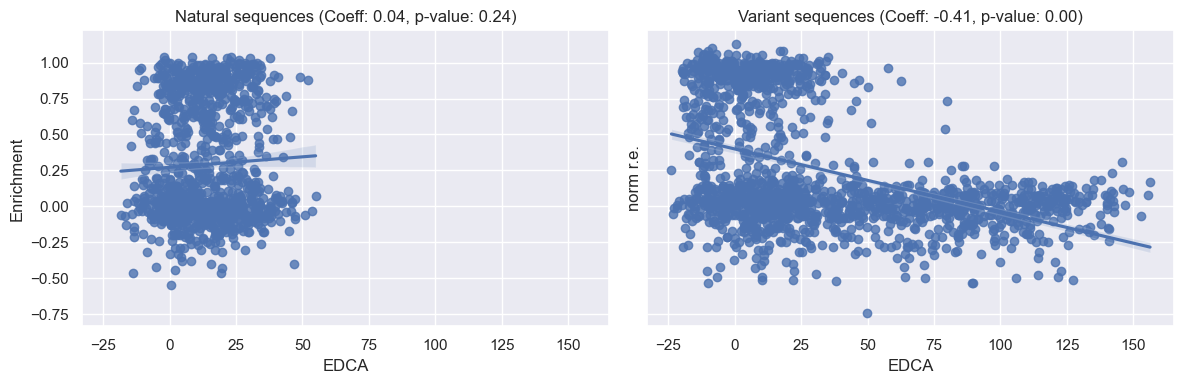

In [7]:
import seaborn as sns
from scipy.stats import spearmanr

_, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

natural_corr, natural_p = spearmanr(table_natural['EDCA (rel. to EcCM)'].values, table_natural['norm r.e.'].values)
variant_corr, variant_p = spearmanr(table_variant['EDCA (rel. to EcCM)'].values, table_variant['norm r.e.'].values)

sns.regplot(data=table_natural, x='EDCA (rel. to EcCM)', y='norm r.e.', ax=axs[0])
axs[0].set_title(f'Natural sequences (Coeff: {natural_corr:.2f}, p-value: {natural_p:.2f})')
axs[0].set_xlabel("EDCA")
axs[0].set_ylabel("Enrichment")

sns.regplot(data=table_variant, x='EDCA (rel. to EcCM)', y='norm r.e.', ax=axs[1])
axs[1].set_title(f'Variant sequences (Coeff: {variant_corr:.2f}, p-value: {variant_p:.2f})')
axs[1].set_xlabel("EDCA")

plt.tight_layout()
plt.show()


In the plots displayed above, we examine the relationships between the EDCA and the normalized relative enrichment over EcCM ('norm r.e.') for both 'Natural' and 'Variant' sequences. 

We can see from the 'Natural' plot above that there is no clear relationship between the EDCA of a natural sequence and it's relative enrichment, this is confirmed by a high spearman p-value (0.24) and low correlation coefficient (0.04). 

By contrast, the 'Variant' plot shows a different picture. The data here exhibits a more patterned distribution, suggesting a possible relationship between the two variables. The Spearman correlation coefficient for the 'Variants' dataset is large and negative (~0.4) and the p-value significant (<0.05). Given that a more negative EDCA means a more likely sequence, there appears to be a positive relationship between the statistical liklihood of a sequence and its enrichment.

Lastly, we can also see the span of EDCA is much larger for our variant sequences than natural sequences.


Interestingly, given the E. coli based enrichment assay, we might expect identity to EcCM alone to be a reasonable predictor for enzymatic activity. We find this to be somewhat true (see below):

In [8]:
from Bio import pairwise2

ECCM_sequence = table_natural.query("`ID to EcCM`==1").Sequence[0]

table_natural['EcCM_similarity'] = [pairwise2.align.globalxx(i, ECCM_sequence)[0].score for i in table_natural.Sequence]
table_variant['EcCM_similarity'] = [pairwise2.align.globalxx(i, ECCM_sequence)[0].score for i in table_variant.Sequence]

/Users/jmage/.micromamba/envs/openprotein-sdk/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


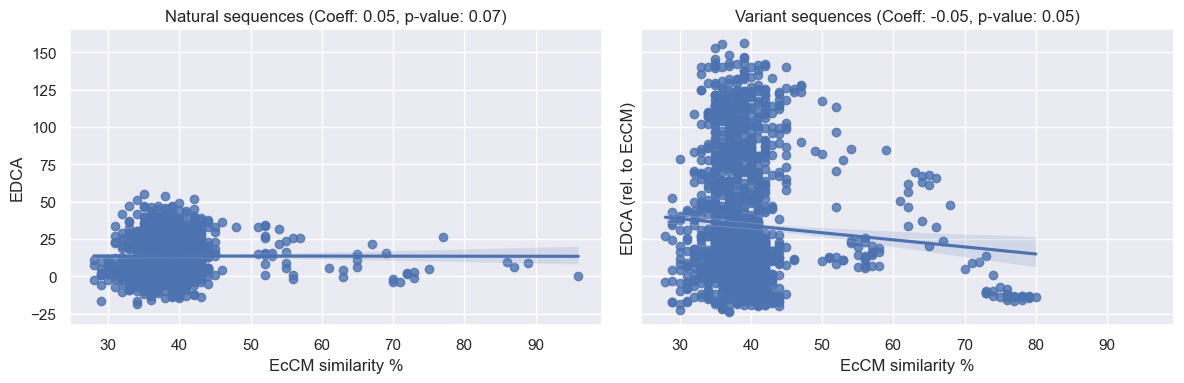

In [9]:
import seaborn as sns
from scipy.stats import spearmanr

_, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

natural_corr, natural_p = spearmanr(table_natural['EcCM_similarity'].values, table_natural['EDCA (rel. to EcCM)'].values)
variant_corr, variant_p = spearmanr(table_variant['EcCM_similarity'].values, table_variant['EDCA (rel. to EcCM)'].values)

sns.regplot(data=table_natural, x='EcCM_similarity', y='EDCA (rel. to EcCM)', ax=axs[0])
axs[0].set_title(f'Natural sequences (Coeff: {natural_corr:.2f}, p-value: {natural_p:.2f})')
axs[0].set_xlabel("EcCM similarity %")
axs[0].set_ylabel("EDCA")

sns.regplot(data=table_variant, x='EcCM_similarity', y='EDCA (rel. to EcCM)', ax=axs[1])
axs[1].set_title(f'Variant sequences (Coeff: {variant_corr:.2f}, p-value: {variant_p:.2f})')
axs[1].set_xlabel("EcCM similarity %")

plt.tight_layout()
plt.show()


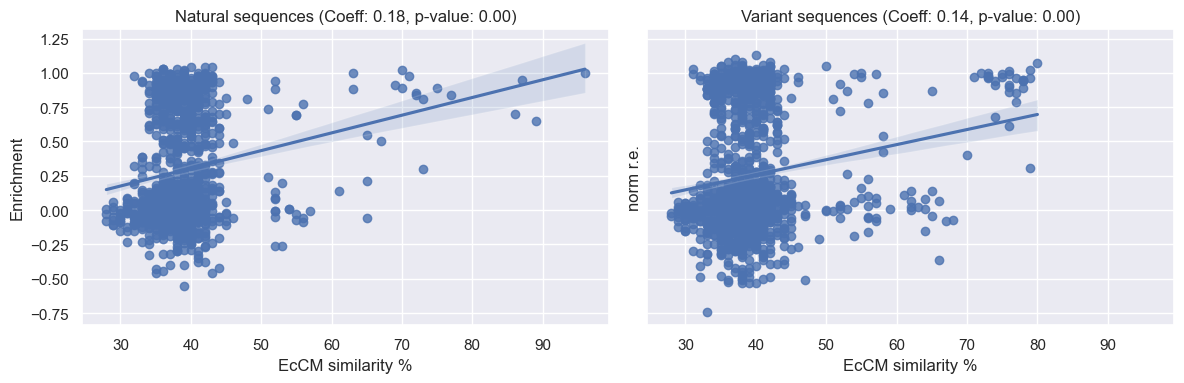

In [10]:
import seaborn as sns
from scipy.stats import spearmanr

_, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

natural_corr, natural_p = spearmanr(table_natural['EcCM_similarity'].values, table_natural['norm r.e.'].values)
variant_corr, variant_p = spearmanr(table_variant['EcCM_similarity'].values, table_variant['norm r.e.'].values)

sns.regplot(data=table_natural, x='EcCM_similarity', y='norm r.e.', ax=axs[0])
axs[0].set_title(f'Natural sequences (Coeff: {natural_corr:.2f}, p-value: {natural_p:.2f})')
axs[0].set_xlabel("EcCM similarity %")
axs[0].set_ylabel("Enrichment")

sns.regplot(data=table_variant, x='EcCM_similarity', y='norm r.e.', ax=axs[1])
axs[1].set_title(f'Variant sequences (Coeff: {variant_corr:.2f}, p-value: {variant_p:.2f})')
axs[1].set_xlabel("EcCM similarity %")

plt.tight_layout()
plt.show()


We can see above that there is a statistically significant relationship between sequence identity to EcCM and relative enrichment, the coeffecients are <0.2 and therefore not particularly strong, but they do present a simple baseline of expectations for model performance. 


Let's now use our PoET model to score these same sequences.

### Generating an MSA and Prompt for PoET

We will build a prompt around the E. coli chorismate mutase sequence, generating an MSA and filtering it to create a curated prompt to evaluate our target sequences on.


In [11]:
seed = table_natural.iloc[0]['Sequence']
seed = seed.replace('-', '')
seed

'TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGKAHHLDAHYITRLFQLIIEDSVLTQQALLQQH'

In [12]:
msa = session.align.create_msa(seed.encode())
print(msa)


job_id='5548acb6-cdc0-4af0-908e-93c96012c19d' job_type=<JobType.align_align: '/align/align'> status=<JobStatus.SUCCESS: 'SUCCESS'> created_date=datetime.datetime(2024, 10, 17, 9, 47, 32, 126851) start_date=None end_date=datetime.datetime(2024, 10, 17, 9, 47, 32, 128787) prerequisite_job_id=None progress_message=None progress_counter=None sequence_length=None


Let's examine the resulting MSA:

We can see the constructed MSA had 3500+ sequences, only 4 of which were found in our natural sequence dataset:

In [13]:
msa_result = pd.DataFrame(list(list(msa.get())), columns=['name','sequence'])
print(f"Number of sequences in the MSA: {msa_result.sequence.nunique()}")

Number of sequences in the MSA: 3741


In [14]:
set(table_natural.Sequence.str.replace("-","").tolist()) & set(msa_result.sequence.str.replace("-","").tolist())

{'EQNLVNLREKISNIDADLLDLLAKRRQLANNIAKTKLLENRPIRDKNRERELLNVLITKGKNRGLDGFYITRLFQMIIEDSVLTQQALLQQH',
 'TENSLLALRERISALDLKLLALLAERRTMAIEVAQSKMHSHRPIRDKEREAELINTLIQEGKKQGLDGHYITRVYQLIIEDSVLTQQALLQQH',
 'TPENPLLDLRVKISALDEKLLALLAERRALAIEVGKAKLDSHRPVRDIDRERDLLERLIQLGKAHHLDAHYITRLFQLIIEDSVLTQQALLQQH',
 'TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGKAHHLDAHYITRLFQLIIEDSVLTQQALLQQH'}

We have generated a large, diverse MSA that can be filtered into a suitable prompt for our PoET Model. 

## Rank the natural and variant sequences

Creating a prompt from an MSA involves filtering the ~3700 sequences to ~100 based on a number of criteria, our aim is for the resulting prompt to successfully encode relevant evolutionary and fitness data that our PoET model can use as context when scoring or generating new sequences.  For now, let's try the default prompt settings:

- `num_residues`: This controls the maximum number of residues (tokens) in the prompt. We'll use the default 12288 here. Which should be roughly X sequences. 
- `method`: This parameter signifies the MSA sampling method to be used. The default method is `NEIGHBORS_NONGAP_NORM_NO_LIMIT`.
- `homology_level`: Applicable for the neighbors methods only, this parameter controls the level of homology for sequences in the MSA. The value ranges between 0 and 1, with the default set at 0.8.
- `max_similarity`: This defines the maximum similarity between sequences in the MSA and the seed, ranging between 0 and 1. By default, it is set to 1.0.
- `min_similarity`: This determines the minimum similarity between sequences in the MSA and the seed, with values ranging from 0 to 1. The default is set at 0.0.
- `always_include_seed_sequence`: This Boolean parameter controls whether to always include the seed sequence in the MSA or not. By default, it is set to False.
- `num_ensemble_prompts`: It denotes the number of ensemble jobs to run, each job will have a different prompt to generate a more diverse set of scores. We will set this value to 3. 
- `random_seed`: The seed allows you to make reproducible runs. We'll set it to 42 here. 


In [15]:
prompt = msa.sample_prompt(num_ensemble_prompts=3, random_seed=42)
print(prompt)

job_id='6def2dce-944d-49bd-be8b-f8963d9fd42c' job_type=<JobType.align_prompt: '/align/prompt'> status=<JobStatus.PENDING: 'PENDING'> created_date=datetime.datetime(2024, 10, 17, 9, 47, 37, 42067) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=None sequence_length=None


In [16]:
prompt.wait() # wait for job to complete

prompt_result = [] 
for i in [1,2,3]:
    prompt_result.append( pd.DataFrame( list(prompt.get(i)) , columns=['name','sequence']) )

We have created 3 prompts, each of 100 sequences. We can see the prompt for the first model (in the ensemble of 3 models) below:

In [17]:
prompt_result[0]

,name,sequence
0,A0A1Y2L7K8,TTKNPCSDVRANVDRVDRLLVALMAERLNYIEQAARIKPTRDAVRD...
1,A0A523L5L1,SDDSLQKLRSQIDAIDDQLLELFNQRAGCAVEVAEVKRKSGGSIFR...
2,A0A7C2R2J8,DINDWRKRIDELDAELVKLLNERSRCAAEVGKLKRKAGTPLYQPER...
3,A0A2A4N5R5,DSTLGELRHLIDDFDQKLLELLENRMQVAKTIGHYKKENNITVLQN...
4,C6XN30,VRYEIDRIDRLLVEILAERTTYIKAASRIKPDREMVRDVPRIEDVV...
...,...,...
95,A0A521G9H4,LQSLRDHIDALDDQLLQLLNQRMDYVRQVGELKRSTNAIIYRPERE...
96,A0A661QGZ3,TNSNLDDLRQRIDLIDNQILGLLNRRAEVVVAVGKAKEGAEKTFYV...
97,A0A7W9KC75,SEHRLSDLRAELDRLDQVLLDTIRRRLECGVQIAEHKAANDVPMMQ...
98,A0A7Y7D3I2,LQDVRDNIDRLDETIVPLLAERIGYVLQAAQFKETRADVRIPPRIE...


Each of the three prompts will satisfy the criteria given above, but will use different sequences to do so. This diversity will enable us to run the model 3 times and get an ensemble of scores for a more robust comparison. 

Let's see how many sequences overlap between the prompts:

In [18]:
overlap = np.zeros((3,3))
seqs = [] 
for i,p1 in enumerate(prompt_result):
    for j,p2 in enumerate(prompt_result):
        overlapped_seqs = list(set(p1['sequence']) & set(p2['sequence']))
        overlap[i,j] = len(overlapped_seqs)
        if i!=j:
            seqs += overlapped_seqs
seqs = list(set(seqs))

In [19]:
pd.DataFrame(overlap, columns=['prompt1','prompt2','prompt3'], index=['prompt1','prompt2','prompt3'],).astype(int)

,prompt1,prompt2,prompt3
prompt1,100,2,5
prompt2,2,100,5
prompt3,5,5,100


We can see a handful of sequences appear more than once, including `TSENPLL`.... which occurs under accession `A0A379UTL6` and `A0A5R1YFZ7` due to being present in 2 different ColabFold sources. 

In [20]:
pd.concat(prompt_result).query("sequence in @seqs").drop_duplicates()

,name,sequence
17,A0A3A1Y7B8,SNRKLELIREDINNIDQQLIDLLSKRRDLSAEVAQYKIKECKPIKD...
24,UPI001423B622,ENPLLVLREKISAVDEKLLTLLAERRALAVDVAQAKLATHRPIRDI...
54,A0A512MB85,DLQAIRVRIDAIDEQLIRLLNERGDLVLEVAEVKKKAGLDIYVPGR...
55,A0A4R2PQ94,DDPLVAARTRIAEIDRTLLDLLAERRAMSRRIAEHKLATGTAVRNT...
96,A0A661QGZ3,TNSNLDDLRQRIDLIDNQILGLLNRRAEVVVAVGKAKEGAEKTFYV...
97,A0A7W9KC75,SEHRLSDLRAELDRLDQVLLDTIRRRLECGVQIAEHKAANDVPMMQ...
6,A0A1E7HTR6,EQELENLRRQLDTIDQNIVSLLAKRQAEVERVVKLKKAHNLPVYHP...
74,A0A2D5QF52,KDKLIQLRDSIDSLDEELLQLINKRASFAVEVANIKEGLGDNTFKP...
89,C6CBA0,TDNPLQALRERITTLDTQLLDLLAQRRELALDVARAKQHSHRPIRD...
93,A0A2D8VTW8,TQNKLDELRSKIDKCDNKILNLLDDRFKIALKIGKLKKDKNLLIEH...


## PoET Scoring

We will now use the 3 diverse prompts above to condition our PoET model and score our database of CM sequences. To do this we will first we remove any gap indicators (`-`) and then we send them to the PoET scoring endpoint:

In [21]:
poet = session.embedding.get_model('poet')

In [22]:
sequences = table_natural['Sequence'].apply(lambda s: s.replace('-', '').encode()).values
print(sequences.shape)

future_natural = poet.score(prompt=prompt, sequences=sequences)
print(future_natural.job)

(1130,)
num_records=3390 job_id='21149f19-305d-43a5-9926-4cc1d69155a7' job_type=<JobType.poet_score: '/poet/score'> status=<JobStatus.PENDING: 'PENDING'> created_date=datetime.datetime(2024, 10, 17, 9, 48, 22, 189239, tzinfo=TzInfo(UTC)) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=0 sequence_length=None


In [23]:
sequences = table_variant['Sequence'].apply(lambda s: s.replace('-', '').encode()).values
print(sequences.shape)

future_variant = poet.score(prompt=prompt, sequences=sequences)

print(future_variant.job)

(1618,)
num_records=4854 job_id='cfac1d68-c607-4661-8da1-117475ee194f' job_type=<JobType.poet_score: '/poet/score'> status=<JobStatus.PENDING: 'PENDING'> created_date=datetime.datetime(2024, 10, 17, 9, 48, 27, 908032, tzinfo=TzInfo(UTC)) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=0 sequence_length=None


We can wait for the jobs to complete, this will auto-fetch the results too:

In [24]:
results_natural = future_natural.wait(verbose=True)
results_variant = future_variant.wait(verbose=True)

print(len(results_natural), len(results_variant))

Waiting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.25it/s, status=SUCCESS]


1130 1618


In [25]:
scores_natural = np.array([r[2] for r in results_natural])
scores_variant = np.array([r[2] for r in results_variant])
scores_natural.shape, scores_variant.shape

((1130, 3), (1618, 3))

In [26]:
score_natural = scores_natural.mean(axis=1)
score_variant = scores_variant.mean(axis=1)
score_natural.shape, scores_variant.shape

((1130,), (1618, 3))

We can now compare the enrichment scores vs the PoET liklihood for this default prompt:

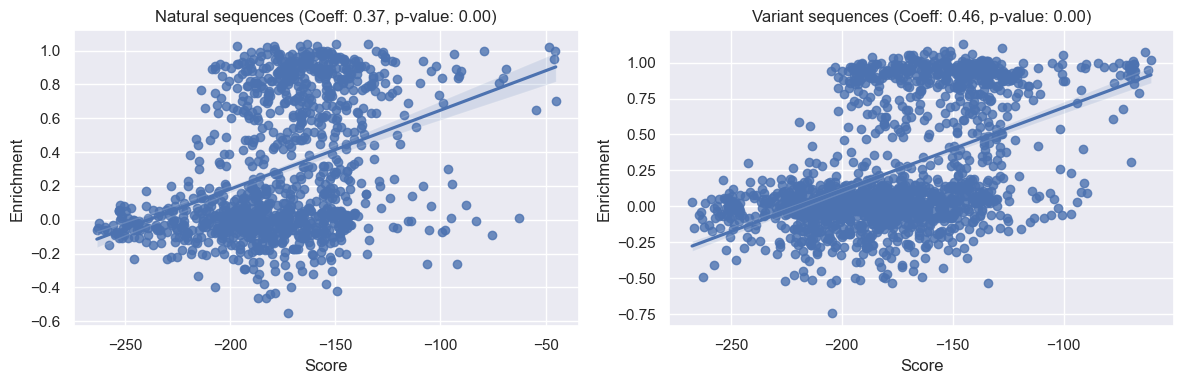

In [27]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))

x = score_natural
y = table_natural['norm r.e.'].values
sns.regplot(x=x, y=y, ax=axs[0])
natural_corr, natural_p = spearmanr(x, y)
axs[0].set_title(f'Natural sequences (Coeff: {natural_corr:.2f}, p-value: {natural_p:.2f})')
axs[0].set_xlabel("Score")
axs[0].set_ylabel("Enrichment")

x = score_variant
y = table_variant['norm r.e.'].values
sns.regplot(x=x, y=y, ax=axs[1])
variant_corr, variant_p = spearmanr(x, y)
axs[1].set_title(f'Variant sequences (Coeff: {variant_corr:.2f}, p-value: {variant_p:.2f})')
axs[1].set_xlabel("Score")
axs[1].set_ylabel("Enrichment")

plt.tight_layout()
plt.show()


We can see above that both the natural sequences and variant sequences correlate strongly with the PoET liklihood scores when conditioned on the default prompt. Both relationships have p<0.05, indicating significance, furthermore we can see the correlation coefficient is stronger for the variant sequences as opposed to the natural sequences (0.5 vs 0.35). 

We can also see that both these coefficients exceed the <0.2 correlation we saw with our simple EcCM identity baseline model. 

Most strikingly, however, we note that both of these results improve upon the EDCA measure we saw above, from *Russ et al 2020*, where the correlation coefficients were ~0.04 and ~0.4 for natural and variant sequences respectively.

Combining these sequences we can see the trend still holds:

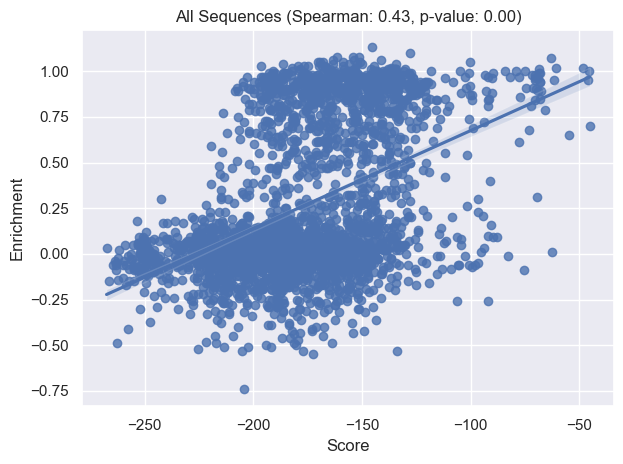

In [28]:
x_combined = np.concatenate([score_natural, score_variant])
y_combined = np.concatenate([table_natural['norm r.e.'].values, table_variant['norm r.e.'].values])
correlation, p_value = spearmanr(x_combined, y_combined)

sns.regplot(x=x_combined, y=y_combined)
plt.title(f'All Sequences (Spearman: {correlation:.2f}, p-value: {p_value:.2f})')
plt.xlabel("Score")
plt.ylabel("Enrichment")
plt.tight_layout()
plt.show()

Lastly let's compare PoET scores to EcCM identity to compare:

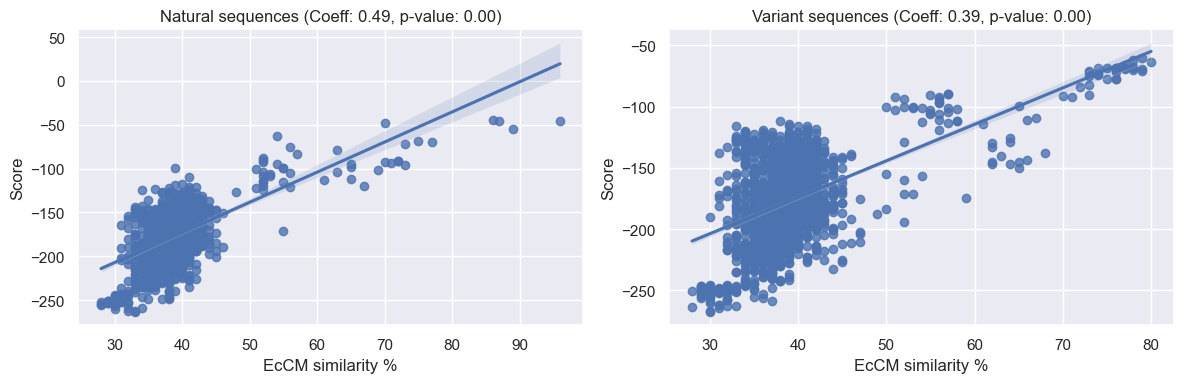

In [29]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))

x = table_natural['EcCM_similarity'].values
y = score_natural
sns.regplot(x=x, y=y, ax=axs[0])
natural_corr, natural_p = spearmanr(x, y)
axs[0].set_title(f'Natural sequences (Coeff: {natural_corr:.2f}, p-value: {natural_p:.2f})')
axs[0].set_ylabel("Score")
axs[0].set_xlabel("EcCM similarity %")

x = table_variant['EcCM_similarity'].values
y = score_variant 
sns.regplot(x=x, y=y, ax=axs[1])
variant_corr, variant_p = spearmanr(x, y)
axs[1].set_title(f'Variant sequences (Coeff: {variant_corr:.2f}, p-value: {variant_p:.2f})')
axs[1].set_ylabel("Score")
axs[1].set_xlabel("EcCM similarity %")

plt.tight_layout()
plt.show()


We can see there is a relationship between PoET scores and EcCM similarity. However given that the PoET score v enrichment correlations are much stronger than the similarity vs enrichment correlation, we know the model is learning something more fundamental about protein fitness from the MSA-based prompts. 

## Improving the prompt

We have seen how a default prompt PoET model can generate statistically significant correlations between the experimental relative enrichment and PoET liklihoods. 


Let's now try to improve the prompting by guiding the model with purely natural functional sequences of chorismate mutase. To accomplish this, we will skip the seed -> MSA generation step and supply a read-made MSA instead (containing functional natural sequences only, where functional is defined as a >0.45 enrichment). 

Providing sequences that operate within the natural functional subspace allows us to steer the PoET model's attention towards naturally occurring, functionally viable protein sequences. This focused approach enables the model to discern evolutionary patterns, relationships and constraints more effectively. Consequently, when scoring potential sequences, PoET is better equipped to make accurate and informed predictions that are grounded in naturally observed functionality and diversity. 


In [30]:
table_nat_functional = table_natural.loc[table_natural['norm r.e.'] >= 0.45]
print(table_nat_functional.shape)
table_nat_functional.head()

(407, 8)


,No.,Species,Sequence,ID to EcCM,top ID,EDCA (rel. to EcCM),norm r.e.,EcCM_similarity
0,1,Escherichia coli ...,-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPV...,1.00,0.93,0.00,1.00,96.0
3,4,Enterobacter cloacae subsp. dissolvens SDM ...,-TPENPLLDLRVKISALDEKLLALLAERRALAIEVGKAKLDSHRPV...,0.93,0.93,8.57,0.65,89.0
5,6,Salmonella enterica subsp. enterica serovar Sa...,-TSENPLLALRDKISALDEELLALLAKRRALAIEVGQAKLLSHRPV...,0.90,0.89,9.83,0.70,86.0
6,7,Cronobacter sakazakii ATCC BAA-894 ...,-TAENPLLALRDKISALDEQLLALLAQRRALAVEVGKAKLATHRPV...,0.91,0.90,6.42,0.95,87.0
8,9,Erwinia billingiae Eb661 ...,-TPENPLLGLRDKISALDEQLLNMLAQRRALAIEVATAKMATHRPI...,0.80,0.85,26.25,0.84,77.0


In [31]:
from io import BytesIO

msa_const = session.align.upload_msa(BytesIO(b'\n'.join(table_nat_functional['Sequence'].apply(lambda s: s.encode()))))
print(msa_const)



job_id='b1b00662-4aa8-4b0d-88af-46b402d46d3d' job_type=<JobType.align_align: '/align/align'> status=<JobStatus.SUCCESS: 'SUCCESS'> created_date=datetime.datetime(2024, 10, 17, 9, 49, 19, 152529) start_date=None end_date=datetime.datetime(2024, 10, 17, 9, 49, 19, 152939) prerequisite_job_id=None progress_message=None progress_counter=None sequence_length=None


In [32]:
prompt_const = msa_const.sample_prompt( num_ensemble_prompts=3, random_seed=42)
print(prompt_const)

job_id='67b7ce8e-f0db-414a-af86-e6d25b70133c' job_type=<JobType.align_prompt: '/align/prompt'> status=<JobStatus.PENDING: 'PENDING'> created_date=datetime.datetime(2024, 10, 17, 9, 49, 20, 885660) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=None sequence_length=None


In [33]:
sequences = table_variant['Sequence'].apply(lambda s: s.replace('-', '').encode()).values
print(sequences.shape)


future_variant_const = poet.score(prompt=prompt_const, sequences=sequences)

print(future_variant_const.job)

(1618,)
num_records=4854 job_id='4f8282dd-9ed6-407c-8859-bbb99ddd2a95' job_type=<JobType.poet_score: '/poet/score'> status=<JobStatus.PENDING: 'PENDING'> created_date=datetime.datetime(2024, 10, 17, 9, 49, 26, 879280, tzinfo=TzInfo(UTC)) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=0 sequence_length=None


We can again wait for the job to complete.

In [34]:
results_variant_const = future_variant_const.wait(verbose=True)
print(len(results_variant_const))

Waiting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s, status=SUCCESS]


1618


In [35]:
scores_variant_const = np.array([r[2] for r in results_variant_const])
score_variant_const = scores_variant_const.mean(axis=1)
scores_variant_const.shape, score_variant_const.shape

((1618, 3), (1618,))

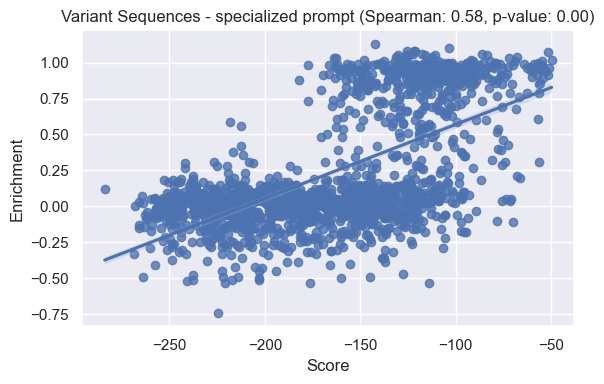

In [36]:
_, ax = plt.subplots(figsize=(6, 4))

x = score_variant_const
y = table_variant['norm r.e.'].values


correlation, p_value = spearmanr(x, y)

sns.regplot(x=x, y=y)
plt.title(f'Variant Sequences - specialized prompt (Spearman: {correlation:.2f}, p-value: {p_value:.2f})')
plt.xlabel("Score")
plt.ylabel("Enrichment")
plt.tight_layout()
plt.show()

We can see above that the specialised prompt has improved the spearman correlation from 0.5 (for default prompt parameters) to 0.55 for the variant dataset.

## Sequence generation

Given the good performance of this prompt in scoring sequences, we can re-use it to generate novel sequences *de novo*. 

In [37]:
future_gen = poet.generate(prompt_const, num_samples=1000, topp=0.9)
print(future_gen.job)

num_records=1000 job_id='894afa58-f6c4-4167-bd10-bdb5aff832e2' job_type=<JobType.poet_generate: '/poet/generate'> status=<JobStatus.PENDING: 'PENDING'> created_date=datetime.datetime(2024, 10, 17, 9, 50, 1, 236919, tzinfo=TzInfo(UTC)) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=0 sequence_length=None


In [38]:
results_gen = future_gen.wait(verbose=True)
print(len(results_gen))

Waiting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:21<00:00,  5.61s/it, status=SUCCESS]


1000


Let's look at the top scoring sequences that were generated:

In [39]:
sample_names = np.array([s[0] for s in results_gen])
sample_sequences = np.array([s[1] for s in results_gen])
sample_scores = np.array([s[2] for s in results_gen]).mean(axis=1)
order = np.argsort(-sample_scores)
for i in order[:10]:
    print(sample_names[i], sample_scores[i], sample_sequences[i], sep='\t')

generated-sequence-782	-14.697639333333333	EVYEELFAMRRSIDNFDAALVHILAERFQATKRVGILKAKHNLPAGDPGREEAQIARLRAMAKSSLDPDFAEKFLNFIISEVIRHHVRIANEQ
generated-sequence-673	-22.986757333333333	DQNNLLKIREKVSELDLKLLILLAERRQLASDIAQTKLQYNRPIRDKDRERELLDVLTKKGKSYGLDGFYISRLFQMIIEDSVLTQQALLQQH
generated-sequence-499	-27.346926	MGLEAIRQDINAVDRQLIALLEKRMALVDQVAAYKQVHDVPVLDQQREAEVLRSVSQQIRQAFEPAILALFKAIMAASRRYQAEQIAVG
generated-sequence-726	-28.807790999999998	DVRAELARLRASIDNIDAAVVHMLAERFKCTQQVGHLKAQHHLPPADPAREARQIARLRQLAEAKLDPAFAEKLLNFIIAEVIRHHEQIADQP
generated-sequence-516	-29.91244766666667	MSELEAVRKEIEEIDREILSLIDKRVNLAERVLESKRINGTSINDRKQNEVVINRALHAATLNLDIGSIKDIFEILIRMSIERQNELSGKG
generated-sequence-237	-34.573171	PEKLSIDELRHEIDRLDAEILAAVKRRTEVSQAIGKVRMASGGTRLVHSREMKVIERYSELGDGKDLAILLLRLGRGRLGH
generated-sequence-987	-36.74955566666667	DIRAELEDIRASIDNIDAALVHLLAERFKCTQRVGRLKATHDLPPSDPGREERQIARLRALAGADLDPAFAEKFLTFIIDEVIRHHEAIRS
generated-sequence-77	-37.99225366666666	DTLENLRAQINVVDGQLIDLLGKRMKVADQIGELKKEQNV

We can also compare (below) the scores for the generated sequences with the scores of the variants from *Russ 2020*. Note that the generated sequences (orange) are generally right-shifted (i.e. higher scoring). Given the strong correlation (>0.5) we saw above between enrichment performance and PoET score, there is reason to believe these *de novo* generated sequences will perform better than the EDCA ranked sequences.

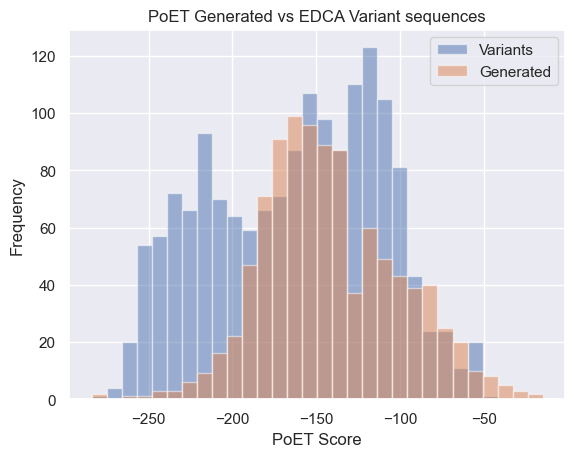

In [40]:
plt.title("PoET Generated vs EDCA Variant sequences")
mi = np.min(score_variant_const)
ma = max(np.max(score_variant_const), np.max(sample_scores))
bins = np.linspace(mi, ma, 31)

plt.xlabel("PoET Score")
plt.ylabel("Frequency")
_ = plt.hist(score_variant_const, bins=bins, alpha=0.5, label='Variants')
_ = plt.hist(sample_scores, bins=bins, alpha=0.5, label="Generated")
plt.legend();

### Generated sequences

Let's also compare the top ranked sequences to the original EcCM:

In [41]:
from Bio import pairwise2
import Bio.Align.substitution_matrices
blosum62 = Bio.Align.substitution_matrices.load('BLOSUM62')

In [42]:
for i in order[:5]:
    print("---"*10)
    x = sample_sequences[i]
    print(f'>{sample_names[i]} {sample_scores[i]}')
    for a in pairwise2.align.globalds(seed, x, blosum62, -11, -1):
        print(pairwise2.format_alignment(*a))
        
        break

------------------------------
>generated-sequence-782 -14.697639333333333
TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGKAHHLDAHYITRLFQLIIEDSVLTQQALLQQH
.....|.|.|..|...|..|...||||......||..|.....|..|..||.....||....|. .||..........||..............
EVYEELFAMRRSIDNFDAALVHILAERFQATKRVGILKAKHNLPAGDPGREEAQIARLRAMAKS-SLDPDFAEKFLNFIISEVIRHHVRIANEQ
  Score=74

------------------------------
>generated-sequence-673 -22.986757333333333
TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGKAHHLDAHYITRLFQLIIEDSVLTQQALLQQH
 ..|.||..|||.|.||.|||.||||||.||......||...||.||.||||.||..|...||...||..||.||||.||||||||||||||||
-DQNNLLKIREKVSELDLKLLILLAERRQLASDIAQTKLQYNRPIRDKDRERELLDVLTKKGKSYGLDGFYISRLFQMIIEDSVLTQQALLQQH
  Score=275

------------------------------
>generated-sequence-499 -27.346926
TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGKAHHLDAHYITRLFQLIIEDSVLTQQALLQQH
..   |.|.|..|.|.|..|.|||..|..|...|...|.....||.|..||...|.............|  |..||..|...|...|.......

We can see there is significant sequence diversity in the generated sequences Vs EcCM. Given the histogram above, we might expect some of these newly generated sequences to outperform the original variants from Russ 2020.

## Sequence UMAP

We can gain more insight into the sequence space occupied by our generated sequences vs the variant and natural sequences in our original dataset by running a UMAP dimension reduction and visualization pipeline.


To visualize the generated sequences in the same space as the natural and variant sequences from the paper, we need to use an external multiple sequence alignment tool, we'll ouput a fasta, run the alignment elsewhere, and and save the subsequent results to `data/chorismate_mutase_combined_seqs.clustal` to use in this notebook.

In [43]:
seqs = np.stack(
    [np.frombuffer(s.encode().upper(), dtype=np.uint8) for s in table_natural['Sequence']] + [np.frombuffer(s.encode().upper(), dtype=np.uint8) for s in table_variant['Sequence']]
)
seqs.shape

(2748, 96)

In [44]:
with open('data/chorismate_mutase_combined_seqs.fasta', 'wb') as f:
    for i in range(len(table_natural)):
        name = f'>Natural_{i+1}'.encode()
        f.write(name)
        f.write(b'\n')
        f.write(table_natural.iloc[i]['Sequence'].encode().replace(b'-', b''))
        f.write(b'\n')
    for i in range(len(table_variant)):
        name = f'>Variant_{i+1}'.encode()
        f.write(name)
        f.write(b'\n')
        f.write(table_variant.iloc[i]['Sequence'].encode().replace(b'-', b''))
        f.write(b'\n')
    for i in range(len(sample_sequences)):
        name = f'>poet_generated_{i+1}'.encode()
        f.write(name)
        f.write(b'\n')
        f.write(str(sample_sequences[i]).encode())
        f.write(b'\n')

In [45]:
import csv
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment

def csv_to_alignment(csv_file):
    # Open the CSV and read the sequences
    alignment = MultipleSeqAlignment([])
    with open(csv_file, mode='r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Create a SeqRecord for each row
            record = SeqRecord(Seq(row[1]), id=row[0])
            alignment.append(record)
    return alignment

alignment = csv_to_alignment("data/chorismate_mutase_combined_seqs.csv")
# count = SeqIO.write(records, "THIS_IS_YOUR_OUTPUT_FILE.clustal", "clustal")
# from Bio import AlignIO

# with open('data/chorismate_mutase_combined_seqs.csv') as f:
#     alignment = AlignIO.read(f, 'csv')

In [46]:
aln = np.stack([np.frombuffer(str(s.seq).encode().upper(), dtype=np.uint8) for s in alignment])

groups = []
measure = []
for i in range(len(alignment)):
    tokens = alignment[i].id.split('_')
    g = '_'.join(tokens[:-1])
    j = int(tokens[-1]) - 1
    v = np.nan
    if g == 'Variant':
        v = table_variant.iloc[j]['norm r.e.']
    elif g == 'Natural':
        v = table_natural.iloc[j]['norm r.e.']

    groups.append(g)
    measure.append(v)
measure = np.array(measure)
groups[:10], measure[:10]

(['Natural',
  'Natural',
  'Natural',
  'Natural',
  'Natural',
  'Natural',
  'Natural',
  'Natural',
  'Natural',
  'Natural'],
 array([ 1.  , -0.06,  0.04,  0.65, -0.08,  0.7 ,  0.95, -0.06,  0.84,
        -0.05]))

In [47]:
umap = UMAP(metric='hamming')
z = umap.fit_transform(aln)

/Users/jmage/.micromamba/envs/openprotein-sdk/lib/python3.10/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


We can see below a UMAP representation of the CM natural sequences (blue) and the subset of sequences that are functional (defined as an enrichment of >0.45). Whilst there is overall good overlap, we can see that some natural sequences that are non-functional clearly cluster together:

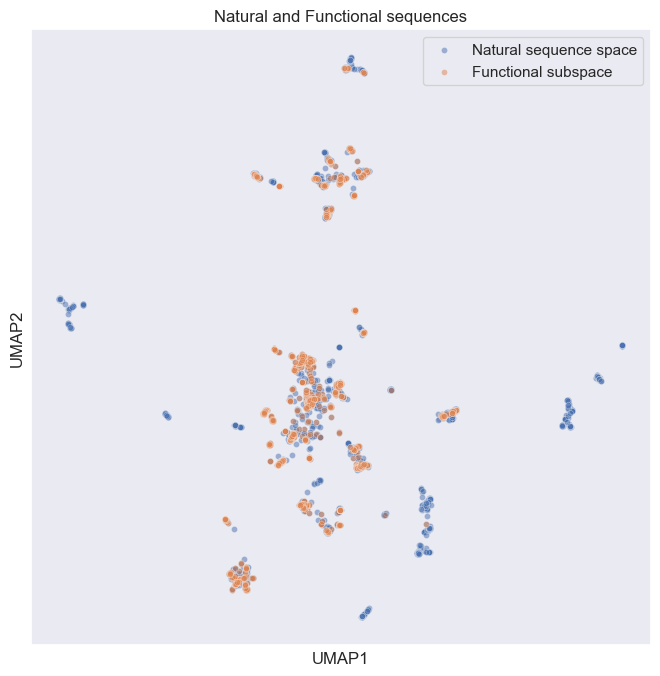

In [48]:
fig = plt.figure(figsize=(8,8))
s = 20

loc = ~np.isnan(measure)
sns.scatterplot(x=z[loc, 0], y=z[loc, 1], data=None, alpha=0.5, s=s, label='Natural sequence space')

loc = ~np.isnan(measure) & (measure > 0.45)
sns.scatterplot(x=z[loc, 0], y=z[loc, 1], data=None, alpha=0.5, s=s, label='Functional subspace')

plt.legend(loc='best')
plt.title("Natural and Functional sequences")
plt.xticks([])
plt.yticks([]);
plt.xlabel("UMAP1")
plt.ylabel("UMAP2");

We can now add in our generated PoET sequences (green):

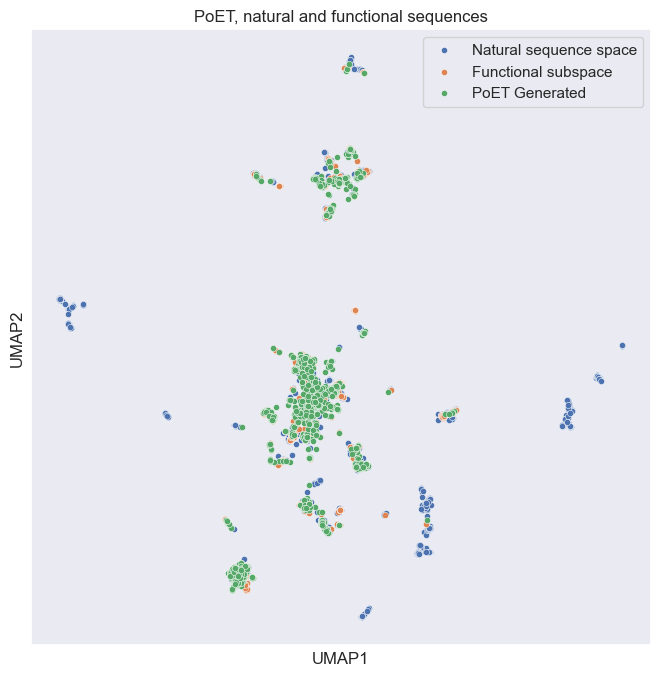

In [49]:
fig = plt.figure(figsize=(8,8))
s = 20

loc = ~np.isnan(measure)
sns.scatterplot(x=z[loc, 0], y=z[loc, 1], s=s, label='Natural sequence space')

loc = ~np.isnan(measure) & (measure > 0.45)
sns.scatterplot(x=z[loc, 0], y=z[loc, 1], s=s, label='Functional subspace')

loc = np.isnan(measure)
sns.scatterplot(x=z[loc, 0], y=z[loc, 1], s=s, label='PoET Generated')

plt.legend(loc='best')
plt.xticks([])
plt.yticks([])
plt.xlabel("UMAP1")
plt.ylabel("UMAP2");
plt.title("PoET, natural and functional sequences");

We can see above that the PoET generated sequences do a good job of covering the functional subspace areas (represented by the overlay of green and orange dots). And rarely overlap with the natural, but non CM functional sequences. This suggests PoET is correctly inferring functional properties based on our CM prompt, and again that these sequences might be fruitful for further wetlab analysis!

Lastly, we can make a gif of these results to overlay them one-by-one:

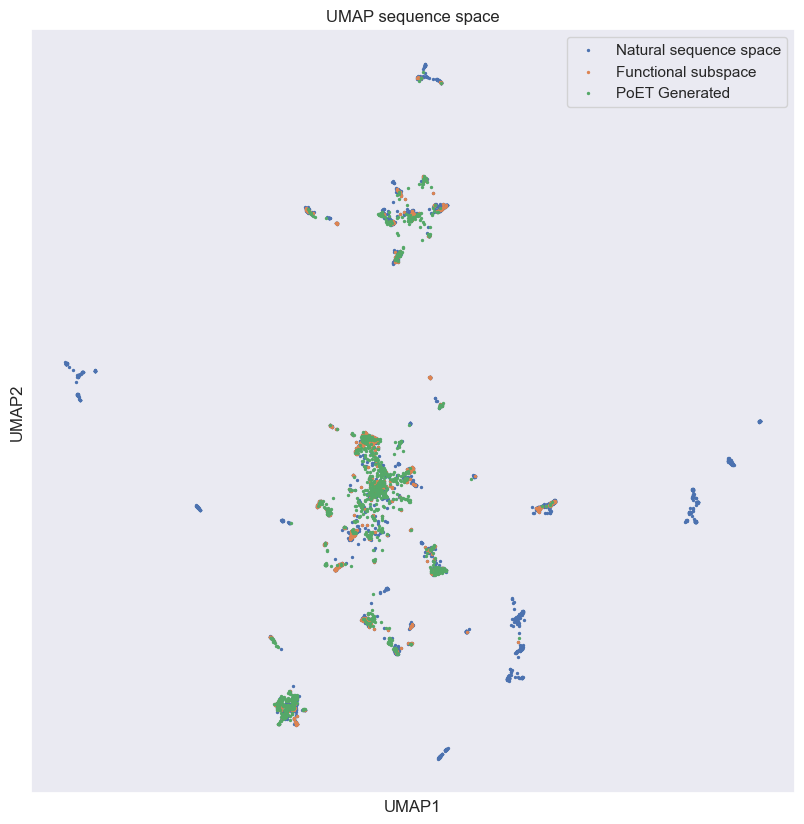

In [50]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(8,8))
s = 2.0

loc = ~np.isnan(measure)
plt.scatter(z[loc, 0], z[loc, 1], s=s, label='Natural sequence space')
plt.legend(loc='best')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

def animate(step):
  if step == 1:
    loc = ~np.isnan(measure) & (measure > 0.45)
    plt.scatter(z[loc, 0], z[loc, 1], s=s, label='Functional subspace')
  if step == 2:
    loc = np.isnan(measure)
    plt.scatter(z[loc, 0], z[loc, 1], s=s, label='PoET Generated')
  plt.legend(loc='best')


animation = FuncAnimation(
  fig, 
  animate, 
  frames=[0, 1, 2],
  interval=5.0,
)

animation.save(
  'chorismate_umap.gif', 
  dpi=300,
  fps=1.0,
)
plt.title("UMAP sequence space");
plt.xlabel("UMAP1")
plt.ylabel("UMAP2");

## Summary 

In this tutorial we have taken a dataset of Chorismate mutase proteins that have associated wetlab measurements (relative enrichment). We have shown that PoET can accurately score CM variants and natural sequences and that our off-the-shelf solution performs better than another method (Russ, 2020) based on EDCA. Specifically, we are able to achieve a correlation between PoET and enrichment of 0.35 & 0.5 vs 0.04 and 0.41 for natural and variant sequences respectively. 

Furthermore, we develop novel CM sequences that may display superior enrichment vs the Russ (2020) proposed sequences. 

Overall, we have used PoET to generate new sequences without costly wetlab experimentation and without prior measurements. We could take these sequences for downstream wetlab assays to kickstart a productive protein engineering cycle!